In [5]:
import matplotlib.pyplot as plt
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from statistics import median

seed = 812
np.random.seed(seed)
tf.random.set_seed(seed)
keras.utils.set_random_seed(seed)
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.experimental.enable_op_determinism()

In [6]:
df = pd.read_csv('../data/processed/AAPL_preprocessed_dataset_with_features.csv')

In [7]:
selected_columns = ["Close", "Volume", "total_news_count", "finbert_label_negative_sum", "finbert_label_positive_sum", "finbert_label_neutral_sum", "finbert_majority_vote", "finbert_count_positive", "finbert_count_negative", "finbert_count_neutral", "Float_Price"]
df = df[selected_columns]
df.dropna(inplace=True)
display(df.head())

,Close,Volume,total_news_count,finbert_label_negative_sum,finbert_label_positive_sum,finbert_label_neutral_sum,finbert_majority_vote,finbert_count_positive,finbert_count_negative,finbert_count_neutral,Float_Price
0,155.992386,105342000,44,10.846443,7.100850,26.052707,1,28,5,11,152.262787
1,152.262787,96970100,45,6.628175,11.337815,27.034010,1,31,9,5,148.218353
2,148.218353,108732100,53,20.435983,9.402243,23.161774,1,24,8,21,152.617081
3,152.617081,92964300,31,6.505516,7.801909,16.692576,1,17,7,7,157.045319
4,157.045319,102300200,29,3.614294,7.921057,17.464650,1,19,8,2,158.058884


In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
def normalize_data(df):
  # Normalize the data
  sc = MinMaxScaler(feature_range=(0,1))
  data_set_scaled = sc.fit_transform(df)
  return data_set_scaled

data_set_scaled = normalize_data(df)
data_set_scaled

array([[0.23979812, 0.27791042, 0.52702703, ..., 0.2173913 , 0.32352941,
        0.21220261],
       [0.21220261, 0.24957386, 0.54054054, ..., 0.39130435, 0.14705882,
        0.18227763],
       [0.18227763, 0.28938497, 0.64864865, ..., 0.34782609, 0.61764706,
        0.21482405],
       ...,
       [0.69785585, 0.0561319 , 0.06756757, ..., 0.08695652, 0.02941176,
        0.72915393],
       [0.72915393, 0.142377  , 0.04054054, ..., 0.        , 0.        ,
        0.73699691],
       [0.73699691, 0.04460387, 0.14864865, ..., 0.08695652, 0.02941176,
        0.74217623]])

In [9]:
backcandles = 30
nb_input_features = 10

def prepare_data_for_lstm_and_split(data_set_scaled, nb_input_features, backcandles, testing=False):
  X = []
  for j in range(nb_input_features):
      X.append([])
      for i in range(backcandles, data_set_scaled.shape[0]):
          X[j].append(data_set_scaled[i-backcandles:i, j])

  X=np.moveaxis(X, [0], [2])
  X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
  y=np.reshape(yi,(len(yi),1))
  print("X shape: ", X.shape)
  print("Y shape: ", y.shape)
  if testing:
    return X, y
  else:
    splitlimit = int(len(X)*0.8)
    X_train, X_test = X[:splitlimit], X[splitlimit:]
    y_train, y_test = y[:splitlimit], y[splitlimit:]
    print("X train:", X_train.shape)
    print("X test:", X_test.shape)
    print("y train: ",y_train.shape)
    print("y test: ",y_test.shape)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_data_for_lstm_and_split(data_set_scaled, nb_input_features, backcandles)

X shape:  (738, 30, 10)
Y shape:  (738, 1)
X train: (590, 30, 10)
X test: (148, 30, 10)
y train:  (590, 1)
y test:  (148, 1)


In [10]:


backcandles = 30  # Define this based on your data (number of time steps)
features = 10  # Number of features per time step

# Define inputs
lstm_input = Input(shape=(backcandles, features), name='lstm_input')

# Build LSTM layers
x = LSTM(150, return_sequences=True, name='first_layer')(lstm_input)
x = LSTM(250, name='second_layer')(x)
x = Dropout(0.5, name='dropout_layer')(x)

# Output layer for regression (no activation for direct value prediction)
outputs = Dense(1, name='dense_layer')(x)  # Linear activation by default for regression

# Create the model
model = Model(inputs=lstm_input, outputs=outputs)

# Optimizer and compilation for regression
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam,
              loss='mean_squared_error',  # Changed to MSE for regression
              metrics=['mean_absolute_error','root_mean_squared_error'])  # MAE is a good metric for regression

# Model summary
model.summary()

# Assuming X_train and y_train are prepared
# For regression, y_train should contain actual difference values, not binary classes
# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)         │ (None, 30, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ first_layer (LSTM)              │ (None, 30, 150)        │        96,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_layer (LSTM)             │ (None, 250)            │       401,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 497,851 (1.90 MB)

 Trainable params: 497,851 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0349 - mean_absolute_error: 0.1420 - root_mean_squared_error: 0.1805 - val_loss: 0.0045 - val_mean_absolute_error: 0.0564 - val_root_mean_squared_error: 0.0668
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0043 - mean_absolute_error: 0.0540 - root_mean_squared_error: 0.0657 - val_loss: 0.0126 - val_mean_absolute_error: 0.0974 - val_root_mean_squared_error: 0.1123
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0033 - mean_absolute_error: 0.0465 - root_mean_squared_error: 0.0576 - val_loss: 0.0086 - val_mean_absolute_error: 0.0775 - val_root_mean_squared_error: 0.0927
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0029 - mean_absolute_error: 0.0430 - root_mean_squared_error: 0.0542 - val_loss: 0.0082 - val_mean_absolute_error: 0.0756 - val_root_mean_squared_error: 0.0904
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0023 - mean_absolute_error: 0.0387 - root_mean_squared_

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

# Assuming y_test and y_pred are already defined from your model's prediction

y_pred = model.predict(X_test)
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# R-squared (R2)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R2): {r2}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Mean Squared Error (MSE): 0.003916588352876531
R-squared (R2): 0.350416400028681


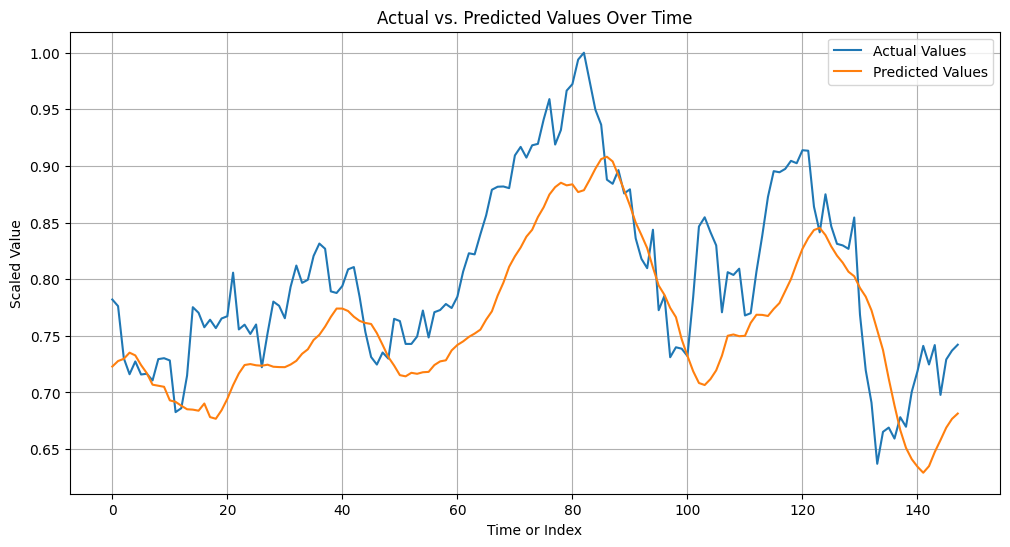

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('Actual vs. Predicted Values Over Time')
plt.xlabel('Time or Index')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)
plt.show()